<a href="https://colab.research.google.com/github/dnjhaha/AML/blob/master/AMLASSIGN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Danni Jin AML Spring 2020 assignment #3
**Setup First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:**

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

**Importing the Required Libraries**

In [0]:
%matplotlib inline
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from keras.utils import np_utils

Preparing the dataset: Load the cifar10 data from Keras. Setup train and test splits. Keras library already consists of all the standard datasets. So, we are just importing cifar10 from the library itself. Then, we use the load_data() method to load the data into the given train and test directories.

In [5]:
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('X_train.shape:', X_train.shape)
print(X_train.shape[0], 'train_samples')
print(X_test.shape[0], 'test_samples')

170500096/170498071 [==============================] - 2s 0us/step
X_train.shape: (50000, 32, 32, 3)
50000 train_samples
10000 test_samples


**Normalize the data**

In [0]:
#from sklearn.preprocessing import label_binarize
X_train=X_train.reshape(X_train.shape[0],32*32*3).astype('float32')
X_test=X_test.reshape(X_test.shape[0],32*32*3).astype('float32')
#y_train = label_binarize(y_train, classes=[0,1,2,3,4,5,6,7,8,9])
#y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
#y_train = np_utils.to_categorical(y_train) 
#y_test = np_utils.to_categorical(y_test) 
#X_train=X_train.astype('float32')
#X_test=X_test.astype('float32')
X_train=X_train/255
X_test=X_test/255


In [7]:
sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [8]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Train a SVM classifier on the dataset , then evaluate the resulting model on the test set.For large datasets consider using sklearn.svm.LinearSVC or sklearn.linear_model.SGDClassifier instead。The multiclass support is handled according to a one-vs-one scheme.

In [9]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=5,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=-inf, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

one-versus-one
(OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers.

In [10]:
len(ovo_clf.estimators_)

45

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.30473391, 0.33791324, 0.36325453])

**use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.**

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)#the explained variance:95% is an elbow where it stops growing fast.
X_train_reduced = pca.fit_transform(X_train)

In [13]:
ovo_clf.fit(X_train_reduced, y_train)
X_test_reduced = pca.transform(X_test)
y_pred = ovo_clf.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.3482

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced.astype(np.float64))
cross_val_score(ovo_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.33935321, 0.34337313, 0.3475339 ])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.26675466490670185
0.2622547549049019
0.30865234609384373


In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(ovo_clf, X_train_scaled, y_train, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[1812,  346,  306,  274,  149,  224,  118,  374,  931,  466],
       [ 259, 2028,  177,  229,  146,  194,  230,  300,  356, 1081],
       [ 368,  269, 1053,  530,  566,  509,  691,  570,  286,  158],
       [ 228,  364,  402, 1247,  306,  931,  618,  358,  228,  318],
       [ 250,  152,  655,  444, 1196,  497,  765,  720,  144,  177],
       [ 206,  284,  456,  991,  405, 1326,  494,  453,  203,  182],
       [  88,  218,  390,  788,  478,  513, 1919,  332,   94,  180],
       [ 240,  287,  365,  380,  416,  426,  275, 2083,  119,  409],
       [ 845,  488,  135,  201,   78,  188,   62,  113, 2260,  630],
       [ 377,  932,  131,  172,  126,  139,  192,  324,  360, 2247]])

In [0]:
y_train_perfect_predictions = y_train

In [19]:
confusion_matrix(y_train, y_train_perfect_predictions)

array([[5000,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 5000,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5000,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 5000,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5000,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5000,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5000,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 5000,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5000,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5000]])

In [20]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_train_pred,average='weighted')

0.340482672500912

In [21]:
recall_score(y_train, y_train_pred,average='weighted')

0.34342

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred,average='weighted')

0.3407102349785773

In [33]:
#from sklearn.model_selection import cross_val_predict
#y_scores = cross_val_predict(ovo_clf, X_train_scaled, y_train, cv=3,method="decision_function")
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred, labels=[0,1,2,3,4,5,6,7,8,9]))

              precision    recall  f1-score   support

           0       0.39      0.36      0.37      5000
           1       0.38      0.41      0.39      5000
           2       0.26      0.21      0.23      5000
           3       0.24      0.25      0.24      5000
           4       0.31      0.24      0.27      5000
           5       0.27      0.27      0.27      5000
           6       0.36      0.38      0.37      5000
           7       0.37      0.42      0.39      5000
           8       0.45      0.45      0.45      5000
           9       0.38      0.45      0.41      5000

    accuracy                           0.34     50000
   macro avg       0.34      0.34      0.34     50000
weighted avg       0.34      0.34      0.34     50000



In [0]:
y_scores = cross_val_predict(ovo_clf, X_train, y_train, cv=3,method="decision_function")

In [26]:
y_scores.shape

(50000, 10)

In [0]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [31]:
from sklearn.metrics import roc_curve
from sklearn import metrics
fpr, tpr = roc_curve(y_train, y_scores)

ValueError: ignored

In [109]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

ValueError: ignored

In [0]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [0]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.show()

NameError: ignored

<Figure size 576x432 with 0 Axes>

# Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
forest_clf.fit(X_train, y_train)
y_pred=forest_clf.predict(X_test)
accuracy_score(y_test, y_pred)



0.3611

In [0]:
from sklearn.metrics import roc_curve, auc
#y_pred = lr.predict_proba(X_test)
#print(roc_auc_score(y_test, y_pred))
# y_score = lr_one_rest.predict_proba(X_test)
y_score = forest_clf.predict_proba(X_test)[:,1]

In [40]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(10):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

TypeError: ignored

In [41]:
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.34895302, 0.34361313, 0.34177367])

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.350093  , 0.34331313, 0.34135365])

In [44]:
cross_val_score(forest_clf, X_train_scaled, y_train[:,1], cv=3, scoring="roc_auc").mean()

IndexError: ignored

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(forest_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


array([[2574,  353,  367,  182,  170,  138,  127,  151,  677,  261],
       [ 462, 2186,  263,  278,  181,  213,  174,  178,  367,  698],
       [ 672,  303, 1387,  470,  764,  358,  489,  291,  134,  132],
       [ 402,  429,  673, 1151,  466,  781,  507,  263,  129,  199],
       [ 411,  263,  964,  447, 1493,  298,  558,  325,  125,  116],
       [ 350,  379,  684,  947,  450, 1345,  376,  279,   92,   98],
       [ 220,  369,  792,  602,  705,  356, 1632,  180,   53,   91],
       [ 444,  399,  540,  515,  604,  408,  288, 1397,  118,  287],
       [ 905,  537,  219,  223,  138,  160,   78,  119, 2319,  302],
       [ 512, 1136,  208,  265,  138,  151,  150,  261,  417, 1762]])

In [0]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


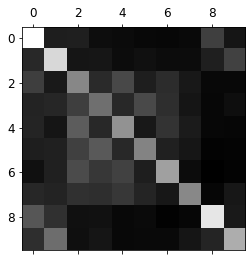

In [0]:

plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [0]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


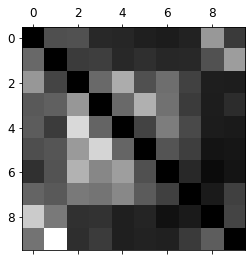

In [0]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [34]:
from sklearn.metrics import roc_curve, auc
#y_pred = lr.predict_proba(X_test)
#print(roc_auc_score(y_test, y_pred))
# y_score = lr_one_rest.predict_proba(X_test)
y_score = forest_clf.predict_proba(X_test)[:,1]

NameError: ignored

In [0]:
if y_score.ndim == 2:
    y_score = y_score[:, 1]

In [114]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(10):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

IndexError: ignored

In [0]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# ROC curves

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores,multi_class="ovo")

ValueError: ignored

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)